In [2]:
import numpy as np
from scipy.stats import dirichlet
import tqdm
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import gamma


def generate_xt(n_pars, hm):
    xt = []
    for _ in range(hm):
        temp = np.linspace(10,1,n_pars) * np.random.uniform(0,1,n_pars)
        xt.append(temp/np.sum(temp))
    return np.array(xt)

def loglikelihood(xt, omega):
    return np.sum( np.log( np.array( [ np.sum(xt[i]*omega) for i in range(len(xt)) ] ) ) )

def log_posterior(xt, omega, alpha):
    return loglikelihood(xt, omega) + dirichlet.logpdf(omega, alpha = alpha)

def sampling(n, xt, alpha, alpha_prop):
    accepted = []
    c = 0
    log_rnd = np.log(np.random.uniform(0,1,n))
    pb = tqdm.tqdm(range(n))
    omega = np.hstack( dirichlet.rvs(alpha = alpha, size = 1) )
    for i in pb:
        acp = i and c/i or 0
        pb.set_description("Acceptance rate %f" % acp)
        omega_new = np.hstack( dirichlet.rvs(alpha = alpha_prop, size = 1) )
        if log_rnd[i] <= log_acceptance_diri(xt, alpha, alpha_prop, omega, omega_new):
            omega = omega_new
            c +=1
        accepted.append(omega)
    return np.array(accepted)

def sampling2(n, xt, alpha, eps, each):
    accepted = []
    c = 0
    log_rnd = np.log(np.random.uniform(0,1,n))
    pb = tqdm.tqdm(range(n))
    x = np.ones(len(alpha)) * len(alpha)
    omega = x/np.sum(x)
    alp = 1/eps**2
    scale = x*eps**2
    for i in pb:
        acp = i and c/i or 0
        pb.set_description("Acceptance rate %f" % acp)
        x_pr = gamma.rvs(alp, scale = scale)
        omega_pr = x_pr/np.sum(x_pr)
        if i % each == 0: print(x_pr)
        if log_rnd[i] <= log_acceptance(xt, alpha, x, x_pr, omega, omega_pr, alp, eps, scale):
            omega = omega_pr
            x = x_pr
            scale = x_pr*eps**2
            c +=1
        accepted.append(omega)
    return np.array(accepted)

def sampling3(n, xt, alpha, eps, each):
    accepted = []
    #prs = []
    c, skpd = [0,0]
    log_rnd = np.log(np.random.uniform(0,1,n))
    pb = tqdm.tqdm(range(n))
    omega = np.hstack( dirichlet.rvs(alpha = alpha, size = 1) )
    for i in pb:
        acp = i and c/i or 0
        skpd_rate = i and skpd/i or 0
        pb.set_description("Acceptance rate %f,    Skipped due to zero in some omega proposed %f" % (acp,skpd_rate))
        omega_pr = np.hstack( dirichlet.rvs(alpha = omega*eps, size = 1) )
        if any(omega_pr==0):
             skpd += 1
             continue
        if i % each == 0: print(omega_pr)
        #omega_pr = np.where(omega_pr>0, omega_pr, 1e-10)
        #omega_pr = omega_pr/np.sum(omega_pr)
        if log_rnd[i] <= log_acceptance3(xt, alpha, omega, omega_pr, eps):
            omega = omega_pr
            c +=1
        accepted.append(omega)
    return np.array(accepted)

def sampling4(n, xt, alpha, eps, each):
    accepted = []
    #prs = []
    c, skpd = [0,0]
    log_rnd = np.log(np.random.uniform(0,1,n))
    pb = tqdm.tqdm(range(n))
    omega = np.hstack( dirichlet.rvs(alpha = alpha, size = 1) )
    for i in pb:
        acp = i and c/i or 0
        skpd_rate = i and skpd/i or 0
        pb.set_description("Acceptance rate %f,    Skipped due to zero in some omega proposed %f" % (acp,skpd_rate))
        omega_pr = np.hstack( dirichlet.rvs(alpha = omega+eps, size = 1) )
        if any(omega_pr==0):
             skpd += 1
             continue
        if i % each == 0: print(omega_pr)
        #omega_pr = np.where(omega_pr>0, omega_pr, 1e-10)
        #omega_pr = omega_pr/np.sum(omega_pr)
        if log_rnd[i] <= log_acceptance4(xt, alpha, omega, omega_pr, eps):
            omega = omega_pr
            c +=1
        accepted.append(omega)
    return np.array(accepted)

def sampling5(n, xt, alpha, eps, each):
    accepted = []
    c = 0
    log_rnd = np.log(np.random.uniform(0,1,n))
    pb = tqdm.tqdm(range(n))
    x = np.hstack( dirichlet.rvs(alpha = alpha, size = 1) )
    omega = x/np.sum(x)
    scale = 1
    for i in pb:
        acp = i and c/i or 0
        pb.set_description("Acceptance rate %f" % acp)
        x_pr = gamma.rvs(x*eps, scale = scale)
        omega_pr = x_pr/np.sum(x_pr)
        if i % each == 0: print(x_pr)
        if log_rnd[i] <= log_acceptance5(xt, alpha, x, x_pr, omega, omega_pr, eps, scale):
            omega = omega_pr
            x = x_pr
            c +=1
        accepted.append(omega)
    return np.array(accepted)

def log_acceptance4(xt, alpha, omega, omega_pr, eps):
            return log_posterior(xt, omega_pr, alpha) - log_posterior(xt, omega, alpha) - dirichlet.logpdf(omega_pr, alpha = omega+eps) + dirichlet.logpdf(omega, alpha = omega_pr+eps)

def log_acceptance3(xt, alpha, omega, omega_pr, eps):
            return log_posterior(xt, omega_pr, alpha) - log_posterior(xt, omega, alpha) - dirichlet.logpdf(omega_pr, alpha = omega*eps) + dirichlet.logpdf(omega, alpha = omega_pr*eps)

def log_acceptance_diri(xt, alpha, alpha_prop, omega, omega_pr):
    return log_posterior(xt, omega_pr, alpha) - log_posterior(xt, omega, alpha) - dirichlet.logpdf(omega_pr, alpha = alpha_prop) + dirichlet.logpdf(omega, alpha = alpha_prop)

def log_acceptance(xt, alpha, x, x_pr, omega, omega_pr, alp, eps, scale):
            scale_reverse = x_pr*eps**2
            return log_posterior(xt, omega_pr, alpha) - log_posterior(xt, omega, alpha) + log_jacobian(x_pr) - log_jacobian(x) + norm.logpdf(np.sum(x_pr), loc = 0, scale = 1) - norm.logpdf(np.sum(x), loc = 0, scale = 1) - np.sum( gamma.logpdf(x_pr, a = alp, scale=scale) ) + np.sum( gamma.logpdf(x, a = alp, scale=scale_reverse) )

def log_acceptance5(xt, alpha, x, x_pr, omega, omega_pr, eps, scale):
            return log_posterior(xt, omega_pr, alpha) - log_posterior(xt, omega, alpha) + log_jacobian(x_pr) - log_jacobian(x) + norm.logpdf(np.sum(x_pr), loc = 0, scale = 1) - norm.logpdf(np.sum(x), loc = 0, scale = 1) - np.sum( gamma.logpdf(x_pr, a = x*eps, scale=scale) ) + np.sum( gamma.logpdf(x, a = x_pr*eps, scale=scale) )

def log_jacobian(x):
    return -(len(x)) * np.log(np.sum(x))



In [3]:
alpha = np.ones(4)*0.5
omega = np.hstack( dirichlet.rvs(alpha = alpha, size = 1) )
x = omega*np.random.normal(len(alpha), len(alpha))

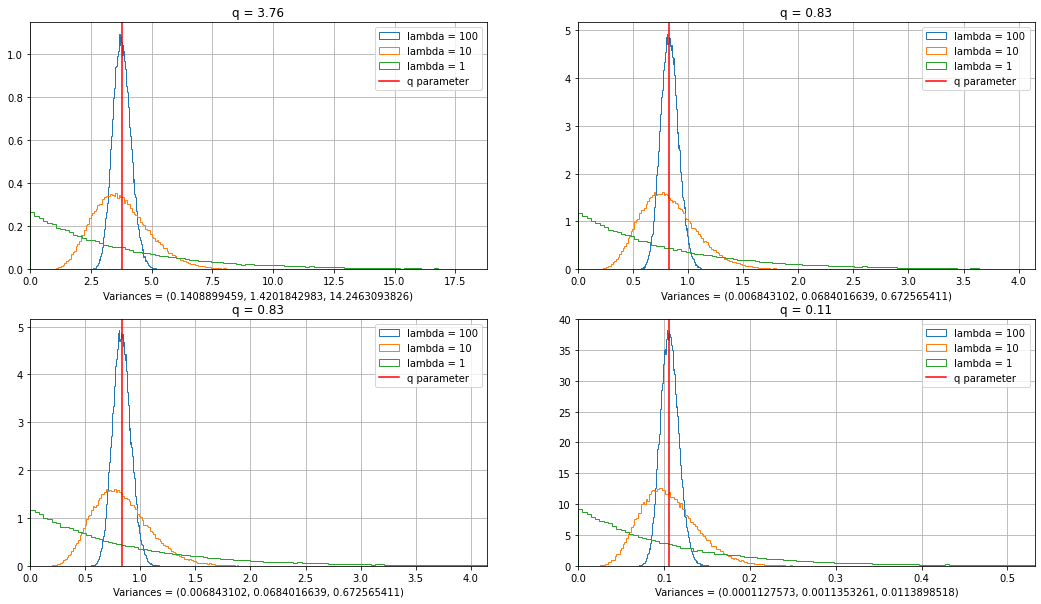

In [4]:
n = int(1e5)

lam1 = 100
alp = lam1
scale = x/lam1
x_pr = gamma.rvs(alp, scale = scale, size=(n,len(alpha)))
#print(x_pr)
omega_pr = np.transpose((np.transpose(x_pr)/(np.sum(x_pr, axis = 1))))
w1 = np.transpose(x_pr)

lam2 = 10
alp = lam2
scale = x/lam2
x_pr = gamma.rvs(alp, scale = scale, size=(n,len(alpha)))
#print(x_pr)
omega_pr = np.transpose((np.transpose(x_pr)/(np.sum(x_pr, axis = 1))))
w2 = np.transpose(x_pr)

lam3 = 1
alp = lam3
scale = x/lam3
x_pr = gamma.rvs(alp, scale = scale, size=(n,len(alpha)))
#print(x_pr)
omega_pr = np.transpose((np.transpose(x_pr)/(np.sum(x_pr, axis = 1))))
w3 = np.transpose(x_pr)

fig, axs = plt.subplots( 2,2, figsize = [18,10] )
for i in range(int(len(alpha)/2)):
    for j in range(int(len(alpha)/2)):
        axs[i,j].hist(w1[i+j], bins = 'auto', histtype='step', density = True, label = f'lambda = {lam1}' )
        axs[i,j].hist(w2[i+j], bins = 'auto', histtype='step', density = True, label = f'lambda = {lam2}')
        axs[i,j].hist(w3[i+j], bins = 'auto', histtype='step', density = True, label = f'lambda = {lam3}')
        axs[i,j].axvline(x=x[i+j], color = 'red', label = 'q parameter')
        axs[i,j].set_xlim([0,x[i+j]*5])
        axs[i,j].grid()
        axs[i,j].set_title(f'q = {np.round(np.mean(x[i+j]),2)}')
        axs[i,j].set_xlabel(f'Variances = { np.round(np.var(w1[i+j]),10), np.round(np.var(w2[i+j]),10), np.round(np.var(w3[i+j]),10) }')
        axs[i,j].legend()
plt.show()
plt.close()

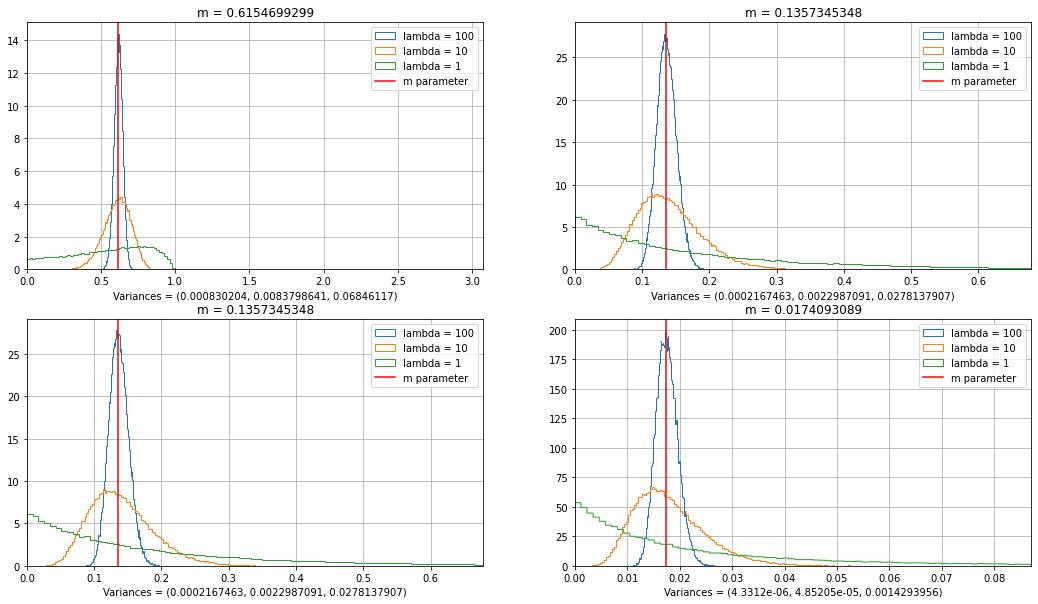

In [5]:
n = int(1e5)

lam1 = 100
alp = lam1
scale = x/lam1
x_pr = gamma.rvs(alp, scale = scale, size=(n,len(alpha)))
#print(x_pr)
omega_pr = np.transpose((np.transpose(x_pr)/(np.sum(x_pr, axis = 1))))
w1 = np.transpose(omega_pr)

lam2 = 10
alp = lam2
scale = x/lam2
x_pr = gamma.rvs(alp, scale = scale, size=(n,len(alpha)))
#print(x_pr)
omega_pr = np.transpose((np.transpose(x_pr)/(np.sum(x_pr, axis = 1))))
w2 = np.transpose(omega_pr)

lam3 = 1
alp = lam3
scale = x/lam3
x_pr = gamma.rvs(alp, scale = scale, size=(n,len(alpha)))
#print(x_pr)
omega_pr = np.transpose((np.transpose(x_pr)/(np.sum(x_pr, axis = 1))))
w3 = np.transpose(omega_pr)

fig, axs = plt.subplots( 2,2, figsize = [18,10] )
for i in range(int(len(alpha)/2)):
    for j in range(int(len(alpha)/2)):
        axs[i,j].hist(w1[i+j], bins = 'auto', histtype='step', density = True, label = f'lambda = {lam1}' )
        axs[i,j].hist(w2[i+j], bins = 'auto', histtype='step', density = True, label = f'lambda = {lam2}')
        axs[i,j].hist(w3[i+j], bins = 'auto', histtype='step', density = True, label = f'lambda = {lam3}')
        axs[i,j].axvline(x=omega[i+j], color = 'red', label = 'm parameter')
        axs[i,j].set_xlim([0,omega[i+j]*5])
        axs[i,j].grid()
        axs[i,j].set_title(f'm = {np.round(np.mean(omega[i+j]),10)}')
        axs[i,j].set_xlabel(f'Variances = { np.round(np.var(w1[i+j]),10), np.round(np.var(w2[i+j]),10), np.round(np.var(w3[i+j]),10) }')
        axs[i,j].legend()
plt.show()
plt.close()

[0.01684736 0.01719082 0.01745984 ... 0.01695092 0.01721996 0.01749323]
[0.0210692  0.01731821 0.01681182 ... 0.01717073 0.01657315 0.01736404]
[0.01176121 0.02093342 0.01427216 ... 0.01021685 0.02043318 0.00990075]


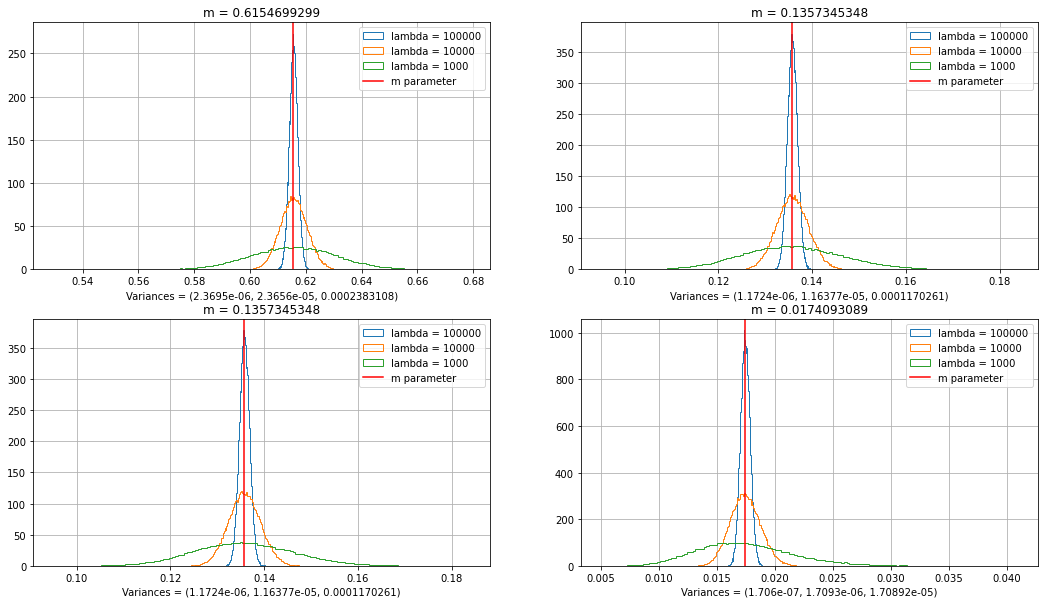

In [6]:
n = int(1e5)

lam1 = 100000
omega_pr = dirichlet.rvs(alpha=omega*lam1, size=n)
#print(omega_pr)
w1 = np.transpose(omega_pr)

lam2 = 10000
omega_pr = dirichlet.rvs(alpha=omega*lam2, size=n)
w2 = np.transpose(omega_pr)

lam3 = 1000
omega_pr = dirichlet.rvs(alpha=omega*lam3, size=n)
w3 = np.transpose(omega_pr)

print(w1[2])
print(w2[2])
print(w3[2])

fig, axs = plt.subplots( 2,2, figsize = [18,10] )
for i in range(int(len(alpha)/2)):
    for j in range(int(len(alpha)/2)):
        axs[i,j].hist(w1[i+j], bins = 'auto', histtype='step', density = True, label = f'lambda = {lam1}' )
        axs[i,j].hist(w2[i+j], bins = 'auto', histtype='step', density = True, label = f'lambda = {lam2}')
        axs[i,j].hist(w3[i+j], bins = 'auto', histtype='step', density = True, label = f'lambda = {lam3}')
        axs[i,j].axvline(x=omega[i+j], color = 'red', label = 'm parameter')
        #axs[i,j].set_xlim([0,1])
        axs[i,j].grid()
        axs[i,j].set_title(f'm = {np.round(np.mean(omega[i+j]),10)}')
        axs[i,j].legend()
        axs[i,j].set_xlabel(f'Variances = { np.round(np.var(w1[i+j]),10), np.round(np.var(w2[i+j]),10), np.round(np.var(w3[i+j]),10) }')
plt.show()
plt.close()

In [50]:
def mu_me_va_diri(n, nn, alphas, lam):
    mus = []
    vari = []
    medie = []
    for _ in tqdm.tqdm(range(nn)):
        alp = dirichlet.rvs(alpha=alphas)[0]
        omegas = np.transpose( dirichlet.rvs(alpha=alp*lam, size = n) )
        mus.append(alp)
        medie.append(np.mean(omegas, axis = 1))
        vari.append(np.var(omegas, axis = 1))
    return np.hstack(mus), np.hstack(medie), np.hstack(vari)

def mu_me_va_gamma(n, nn, alphas, lam):
    mus = []
    vari = []
    medie = []
    alp = lam
    for _ in tqdm.tqdm(range(nn)):
        x = dirichlet.rvs(alpha=alphas)[0]
        omega = x/np.sum(x)
        scale = x/lam
        x_pr = gamma.rvs(alp, scale = scale, size=(n,len(alphas)))
        omegas = (np.transpose(x_pr)/(np.sum(x_pr, axis = 1)))
        mus.append(omega)
        medie.append(np.mean(omegas, axis = 1))
        vari.append(np.var(omegas, axis = 1))
    return np.hstack(mus), np.hstack(medie), np.hstack(vari)


100%|██████████| 1000/1000 [00:25<00:00, 39.73it/s]


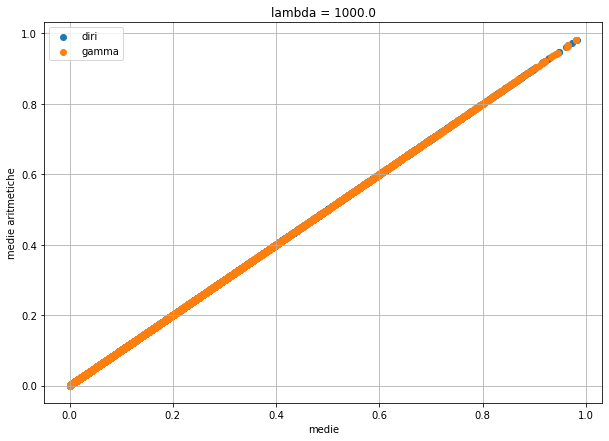

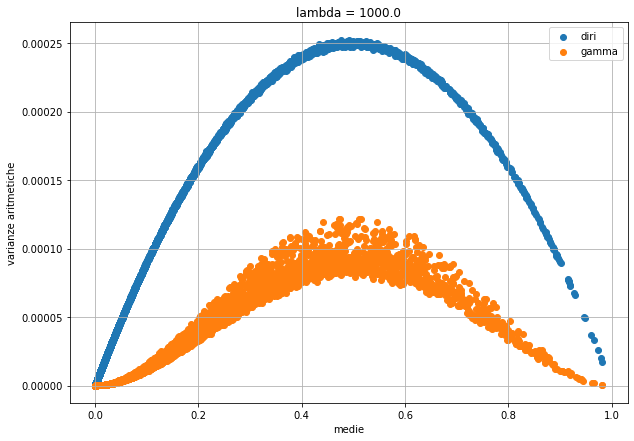

In [54]:
n = int(1e5)
alphas = np.ones(5)*0.5
lam = 1e3
nn = int(1e3)

mus1, medie1, vari1 = mu_me_va_diri(n, nn, alphas, lam)
mus2, medie2, vari2 = mu_me_va_gamma(n, nn, alphas, lam)

plt.figure(figsize = [10,7])
plt.scatter(mus1,medie1, label = 'diri')
plt.scatter(mus2,medie2, label = 'gamma')
plt.xlabel('medie')
plt.ylabel('medie aritmetiche')
plt.title(f'lambda = {lam}')
plt.legend()
plt.grid()

plt.figure(figsize = [10,7])
plt.scatter(mus1,vari1, label = 'diri')
plt.scatter(mus2,vari2, label = 'gamma')
plt.xlabel('medie')
plt.ylabel('varianze aritmetiche')
plt.title(f'lambda = {lam}')
plt.legend()
plt.grid()

100%|██████████| 1000/1000 [00:24<00:00, 40.73it/s]


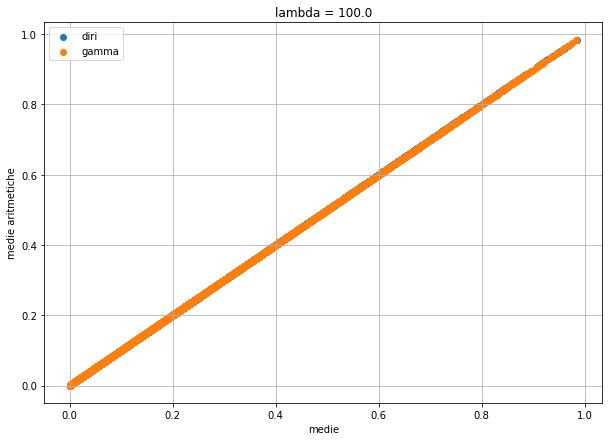

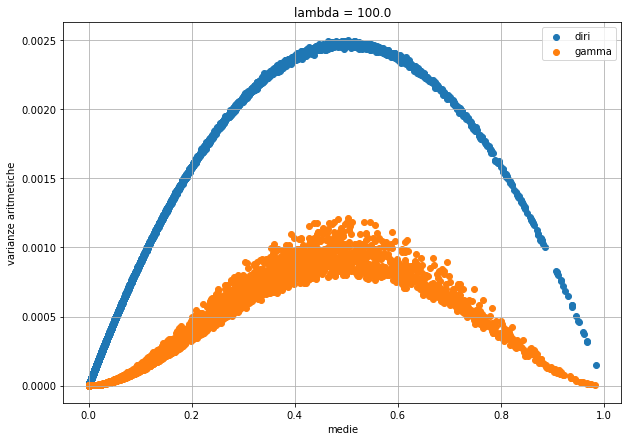

In [55]:
n = int(1e5)
alphas = np.ones(5)*0.5
lam = 1e2
nn = int(1e3)

mus1, medie1, vari1 = mu_me_va_diri(n, nn, alphas, lam)
mus2, medie2, vari2 = mu_me_va_gamma(n, nn, alphas, lam)

plt.figure(figsize = [10,7])
plt.scatter(mus1,medie1, label = 'diri')
plt.scatter(mus2,medie2, label = 'gamma')
plt.xlabel('medie')
plt.ylabel('medie aritmetiche')
plt.title(f'lambda = {lam}')
plt.legend()
plt.grid()

plt.figure(figsize = [10,7])
plt.scatter(mus1,vari1, label = 'diri')
plt.scatter(mus2,vari2, label = 'gamma')
plt.xlabel('medie')
plt.ylabel('varianze aritmetiche')
plt.title(f'lambda = {lam}')
plt.legend()
plt.grid()

100%|██████████| 1000/1000 [00:15<00:00, 64.45it/s]


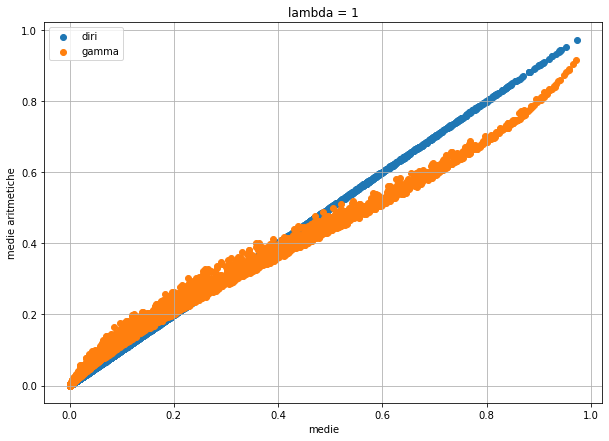

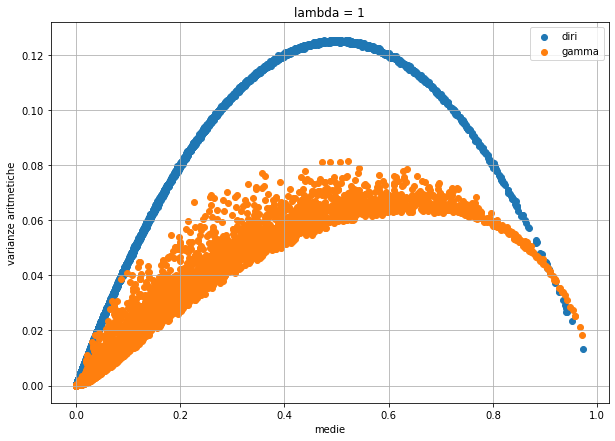

In [56]:
n = int(1e5)
alphas = np.ones(5)*0.5
lam = 1
nn = int(1e3)

mus1, medie1, vari1 = mu_me_va_diri(n, nn, alphas, lam)
mus2, medie2, vari2 = mu_me_va_gamma(n, nn, alphas, lam)

plt.figure(figsize = [10,7])
plt.scatter(mus1,medie1, label = 'diri')
plt.scatter(mus2,medie2, label = 'gamma')
plt.xlabel('medie')
plt.ylabel('medie aritmetiche')
plt.title(f'lambda = {lam}')
plt.legend()
plt.grid()

plt.figure(figsize = [10,7])
plt.scatter(mus1,vari1, label = 'diri')
plt.scatter(mus2,vari2, label = 'gamma')
plt.xlabel('medie')
plt.ylabel('varianze aritmetiche')
plt.title(f'lambda = {lam}')
plt.legend()
plt.grid()